# Project 2: Classification of Drugs by Training on Molecular Data

CHEE 426(G)  Spring 2024

Textbook Chapter 3 & 4.

The basis of this project is a published work by Data Scientist **Andrew White**: https://dmol.pub/ml/classification.html#complete-model

Check the webpage of this orginak work (above) for more details.



## Problem Statement

This Project 2 covers the development of a Classifier to predict the Approval (or Non-approval) by FDA (Food and Drug Administration) of Drugs by training the model on molecular data. It involves concepts and techniques from the Chapter 3 and Chapter 4 of the textbook.

This is also a project where you will compete with each other via **Kaggle** to deveop the best Classifier for this project. Hence, this project has its Kaggle competition page were you will submit your notebook and your predictions to a Test Set that only I know the correct labels (true Y). Therefore, your Kaggle performance from this project will be counted as a seatwork - this is separate from your project grade even though we use the same problem for **Project** and seatwork **Competition** via Kaggle.

**What Is Expected of You Given We Have this Template Notebook?**

Having this template notebook for the project, your task then is to improve the model. Here are possible ways to improve the model according to the discussion of our textbook author:
 - (1) Use only a subset of the X variables.
 - (2) Transform some of the X variables.
 - (3) Use models other than Logistic Regression.

Referring to (3), you may also use techniques not covered by the textbook (note that the textbook is focused on few project examples - few examples but deep analysis and good demo) and there are many algorithms out there other than Logistic Regression to  develop a Classfier.

**Where Do You Go from Here?**

Use this template notebook as a **Base Case** then include your improved model development **by extending the notebook** (add starting at the end of this template notebook). **Requirement: Use Evaluation Metrics for Classification** (Chapter 4) to numerically show the improved performance of your own model compared to the Base Case model.


## Data

The dataset will be downloaded from a GitHub repository via a Pandas function. The dataset was prepared by the MoleculeNet group (Zhenqin Wu, et al. Moleculenet: a benchmark for molecular machine learning. Chemical science, 9(2):513–530, 2018.). 

It is a collection of molecules that succeeded or failed in clinical trials. 

The development of a new drug can cost well over a $1 billion, so any way to predict if a molecule will fail during clinical trials is highly valuable. 

The labels (Y) will be the **FDA_Approved** column which is a 1 or 0 indicating FDA approval status. This is an example of **binary classification**.

## Import (or Install if needed) Python Modules



In [1]:
# Uncomment the installation code below if you hav enot installed the module 'dmol-book' that has the codename 'dmol'
# Keep the comment if you already installed the module in your environment. This is so the install will no happen evertime you run the notebook.

#!pip install dmol-book==1.0.0

# Note: The "!pip" above is a code to call an install via pip from within a jupyter notebook 

In [2]:
# If any of the modules below results to import error, make sure to install the module
# into the environment you are using to run the notebook.
#
# If the module is not available in Anaconda Novigator, highly likely it is in pip repository. Hence, install
# the module via terminal using 'pip install <package name>'. Remember to launch the terminal from
# the Ananconda Navigator Environment, and not from the pure windows terminal. The conda environment must be your environment while installing.
# A sign that the you are in the conda envionment is a show of the environment name as the left-most (first part) of a command line
# in the terminal.
#
# Some of the installs may take a while as these packages (rdkit, jax, mordred) are large.
# You can also try the '!pip' from wihitn the notebook like the dmol-book above.

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import rdkit, rdkit.Chem, rdkit.Chem.Draw
import numpy as np
import jax.numpy as jnp
import mordred, mordred.descriptors
import jax
import dmol

## Import Data

In [3]:
# from zipfile import ZipFile
# from io import BytesIO
# from urllib.request import urlopen

# from web version
# url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz'
# file = urlopen(url).read()
# file = BytesIO(file)
# document = ZipFile(file)
# toxdata = pd.read_csv(document.open('clintox.csv'))

# local version
toxdata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/main/data/clintox.csv.gz"
)

toxdata.head() # this shows the top 5 rows of the data.

# Also chekc the GitHub repo of the data as shown in the URL insede "" above for more details.


,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


### Raw Data and SMILES

The molecular structure under the heading 'smiles' follows the standardized SMILES format of reporting molecular structure. Read more about this SMILES if you want more details: https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system

The SMILES data, however, will be needed to compute the descriptors (X variables) as shown in the following Molecular Descriptors section.

### Molecular Descriptors

This time, our data does not come with pre-computed descriptors. We only have the SMILES string, which is a way of writing a molecule using letters and numbers (a string). We can use rdkit to convert the SMILES string into a molecule, and then we can use a package called Mordred {cite}moriwaki2018mordred to compute a set of descriptors for each molecule. This package will compute around 1500 descriptors (1500 X-variables) for each molecule.

We'll start by converting our molecules into rdkit objects and building a calculator to compute the descriptors.

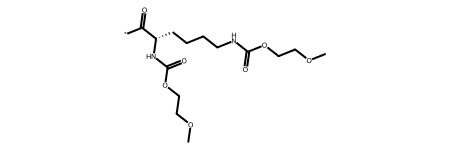

In [4]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# view one molecule to make sure things look good.
molecules[0]

Some of our molecules failed to be converted. We'll have to remove them. We need to remember which ones were deleted too, since we need to remove the failed molecules from the labels.

In [5]:
# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]

In [6]:
# Just checking how many valied samples are there in the dataset:
len(valid_mols)

1480

In [7]:
# Now generating the descriptors (X vars) from the valid molecules
# This will run for some time (seconds to minutes) as the mordred calc extracts the properties of each molecule.


features_raw = calc.pandas(valid_mols)

  4%|▍         | 60/1480 [00:01<00:22, 62.91it/s]

C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 11%|█         | 156/1480 [00:03<00:28, 47.01it/s]

C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 19%|█▉        | 288/1480 [00:06<00:40, 29.77it/s]

C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 24%|██▍       | 361/1480 [00:07<00:19, 57.67it/s]

C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 29%|██▉       | 430/1480 [00:10<00:34, 30.40it/s]

C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 29%|██▉       | 434/1480 [00:11<00:34, 30.40it/s]

C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 72%|███████▏  | 1070/1480 [00:35<00:19, 20.76it/s]

C:\Users\dhanf\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1480/1480 [00:48<00:00, 30.44it/s]


In [8]:
# Check how the table looks:
features_raw

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,28.350244,2.197896,4.395791,28.350244,1.18126,4.008957,...,9.161885,56.087039,333.166176,6.799310,1821,26,98.0,101.0,9.944444,5.944444
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,14.601126,2.414214,4.828427,14.601126,1.216761,3.391683,...,9.542876,43.309911,287.860066,15.992226,174,21,60.0,72.0,6.666667,2.666667
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,0,15.721189,2.297009,4.594017,15.721189,1.122942,3.488592,...,9.213037,44.805422,208.023014,9.455592,309,20,62.0,69.0,8.666667,3.222222
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,3,27.742872,2.335279,4.670559,27.742872,1.26104,3.993146,...,9.795735,55.606004,282.146964,7.234538,1242,32,108.0,123.0,8.277778,5.000000
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,4,34.811061,2.273024,4.546048,34.811061,1.289299,4.180662,...,9.785661,61.056544,342.204479,6.709892,2644,36,126.0,140.0,8.916667,6.388889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,6.188264,24.179697,77.977320,12.996220,9,0,12.0,9.0,3.111111,1.000000
1476,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,4.174387,17.310771,79.937776,26.645925,4,0,6.0,4.0,2.25,1.000000
1477,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,2.0,1.0,2.0,2.0,1.0,1.407606,...,1.098612,7.493061,79.924057,39.962028,1,0,2.0,1.0,2.0,1.000000
1478,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,3,0,4.0,2.0,4.0,4.0,0.8,2.444466,...,7.625107,29.418928,99.956336,16.659389,16,0,20.0,16.0,4.0625,1.000000


The modeling we are doing must use only the numeric descriptors. Examples of non-numeric are the first 2 columns as shown by the error in numpy. Note: Numpy works with numeric data only. Remember that a categorical data can be converted to numeric via One-Hot Encoding, but we will not do that now - we just work with whatever numeric data we have in the dataset.

In [9]:
# Check data types

features_raw.dtypes

ABC          object
ABCGG        object
nAcid         int64
nBase         int64
SpAbs_A      object
             ...   
WPol          int64
Zagreb1     float64
Zagreb2     float64
mZagreb1     object
mZagreb2    float64
Length: 1613, dtype: object

In [10]:
# Note: there are more than 1000 descriptors/columns, so sifting through each column to 'see' data type is not practical.

# First, observe that some numeric columns have been automatically labeled by pandas as object. This is not correct.
# Hence, we force Pandas to convert all possible columns into numeric. 

features = features_raw.astype(float) # Those data that cannot be converted to float will be NaN

# Note: Pay attention to the change of name of the Numpy array. This is a technique in working with notebook - create new var/array out of existing var/array if need to keep raw data.
#
# run this code if you want to see the summary of datatypes: 
# features.dtypes
# features.head()

# We then remove columns with NaN entries as shown in the following cells resulting to lower than 1000 descriptors, around 400


Now we just need to stich everything back together so that our labels are consistent and standardize our features.

In [11]:
labels = toxdata[valid_mol_idx].FDA_APPROVED
features -= features.mean()
features /= features.std()

# we have some nans in features, likely because std was 0
features.dropna(inplace=True, axis=1)

print(f"We have {len(features.columns)} features per molecule")

We have 481 features per molecule


So, the dataset is now ready: Y = labels, and X = features.

That was quite a lenghty pre-processing of data. Sometimes, PRE-PROCESSING is a bottleneck in an ML task. Some Data Scientist sole job is preparing data, which requires a deeper understaning of data structures and transformation techniques. This is a big job that there is a job specialzation called Data Engineering in world of Data Science.

## Exploratory data analysis

In [12]:
# X: Check for null: NA, NaN, etc.
print(f'Total working samples X = {len(features)} \n')

print(f'NULL values in X: \n{features.isnull().sum()} \n')

Total working samples X = 1480 

NULL values in X: 
nAcid        0
nBase        0
nAromAtom    0
nAromBond    0
nAtom        0
            ..
WPath        0
WPol         0
Zagreb1      0
Zagreb2      0
mZagreb2     0
Length: 481, dtype: int64 



In [13]:
# Y: Check for null: NA, NaN, etc.
print(f'Total working samples Y = {len(labels)} \n')
print(f'NULL values in Y: {labels.isnull().sum()} \n')


# Let us check our Y var: FDA-approved drug - "Yes"=1, "No"=0.
print(f'Y levels counts: \n{labels.value_counts()}')

Total working samples Y = 1480 

NULL values in Y: 0 

Y levels counts: 
FDA_APPROVED
1    1386
0      94
Name: count, dtype: int64


Notice that there are way more FDA-approved drugs in our dataset than the drugs that failed FDA approval. This is a limitation inherent to the field of Health Science (not Data Science). Only companies very confident with the success of their drugs will submit their drugs for FDA evaluation. Nonetheless, we, the Data Scientis, must work with the data that we have at hand. So, let us continue.

In [14]:
# To facilitate the correct splitting of the dataset into Testing, Trainig, and Validation sets, 
# let us combine the features(X) dataframe and the labels(Y) dataframe and call it df.

# concatenating X and Y along columns
df = pd.concat([features, labels], axis=1) # axis=1 means column-wise; axis=0 means rowwise.

df = df.dropna()
# Remember to use 'df' dataframe in the succeeding steps.

In [15]:
# Checking dataframe first 5 rows
df.head()

,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2,FDA_APPROVED
0,-0.478046,-0.652093,-1.203569,-1.193150,-0.055375,-0.142306,-0.165193,-0.190777,0.445574,0.029177,...,-0.716841,-0.508565,-0.219626,-0.266773,-0.074258,-0.553496,-0.449909,-0.579923,0.040248,1.0
1,-0.478046,-0.652093,-1.203569,-1.193150,-1.034032,-0.902185,-0.165193,-0.190777,-0.232175,-1.099389,...,-0.364046,-1.082961,-0.414933,1.313113,-0.074259,-0.718699,-0.898844,-0.863021,-0.908968,1.0
2,1.849282,-0.652093,-1.203569,-1.193150,-0.907754,-0.775538,-0.165193,-0.190777,0.106700,-0.980593,...,-0.669475,-1.015730,-0.759098,0.189733,-0.074259,-0.751740,-0.875216,-0.892307,-0.748084,1.0
3,-0.478046,2.323543,-0.300663,-0.318022,-0.371071,-0.268953,-0.165193,-0.190777,-0.401612,-0.386610,...,-0.129900,-0.530190,-0.439561,-0.191975,-0.074258,-0.355253,-0.331768,-0.365159,-0.233255,1.0
4,-0.478046,3.315422,0.602242,0.557106,0.007764,0.047664,-0.165193,-0.190777,-0.232175,0.088576,...,-0.139229,-0.285160,-0.180663,-0.282140,-0.074258,-0.223091,-0.119115,-0.199204,0.168955,1.0


### Spliting Dataset

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [18]:
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

In [19]:
y_train = df_train.FDA_APPROVED
y_val = df_val.FDA_APPROVED
y_test = df_test.FDA_APPROVED

In [20]:
del df_train['FDA_APPROVED']
del df_val['FDA_APPROVED']
del df_test['FDA_APPROVED']

# Since there is no categorical var in our X feature data, no need to do One-Hot Encoding. Hence:

X_train = df_train
X_val = df_val
X_test = df_test


In [21]:
y_train.dtype

dtype('float64')

In [22]:
# Checking 0 and 1 in the y_test. Make sure the are 0's.
y_test.value_counts()

FDA_APPROVED
1.0    274
0.0     22
Name: count, dtype: int64

## Model Training

Since we ought to develop a classifier that will predict the success of getting approved by FDA (1 = FDA-approved, and 0 = Not FDA-approved), we have to implement a classfication ML. We use our Logistic Regression model for two output evels (binay output).

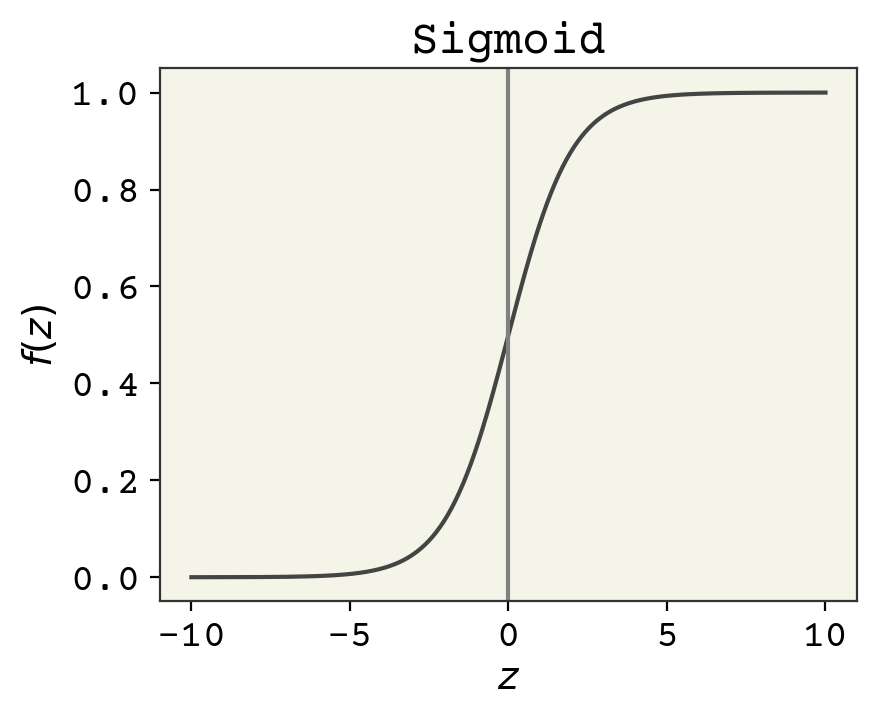

In [23]:
# Recall the logistic regression base-function f(z)=SIGMOID(z):

from myst_nb import glue

z = np.linspace(-10, 10, 500)
y = 1 / (1 + np.exp(-z))
plt.plot(z, y)
plt.xlabel(r"$z$")
plt.ylabel(r"$f(z)$")
plt.axvline(0, color="gray")
plt.title("Sigmoid")
glue("sigmoid", plt.gcf(), display=False)

where $f(z)$ is the **sigmoid** function. The variable $z$ is the linear model wherein we estimate the model parameters $w$ such that: $z=wX=w_{0} + \sum_{i=1}^n w_{i}X_{i}$. Recall the dot-product: $wX$. The molecular descriptors are the model inputs $X_{i}$, which are the data in the dataframe **features** we created above. The sigmoid has a domain of $(-\infty, \infty)$ and outputs a probability $(0, 1)$. The input to the sigmoid can be viewed as log-odds, called **logits** for short. Odds are ratios of probability -- odds of 1 means the probability of the class 1 is 0.5 and class 0 is 0.5. Odds of 2 means the probability of class 1 is 0.67 and class 0 is 0.33. Log-odds is the natural logarithm of that, so that log-odds of 0 means the odds are 1 and the output probability should be 0.5. One definition of the sigmoid is 

\begin{equation}
f(z) = \frac{1}{1 + e^{-z}}
\end{equation}

\begin{equation}
z=wX=w_{0} + \sum_{i=1}^n w_{i}X_{i}
\end{equation}

however in practice there are some complexities to implementing sigmoids to make sure they're numerically stable. This type of binary classifier is sometimes called **logistic regression** because we're regressing logits. 

In essence, all we've done is replacing the inequality of the perceptron with a smooth differentiable version. Just like previously, a positive number indicated class 1 (FDA approved) but now it's a continuum of numbers from 0.5 to 1.0. This is **soft** classification -- we give probabilities of class membership instead of hard assignment. However, our loss function now needs to be modified as well. 



Instead of writing our own code to perform logistic regression, we will use the pre-built function in Scikit-Learn as shown by the textbook author (Chapter 3 and 4): **from sklearn.linear_model import LogisticRegression**. 

So, please review/study/consult the detailed step-by-step implementation and explanation of the code in the Chapter 3 and 4 notebook and videos.


#### Training logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [26]:
model.predict_proba(X_val)

array([[2.37799947e-02, 9.76220005e-01],
       [1.67187473e-02, 9.83281253e-01],
       [2.94479893e-02, 9.70552011e-01],
       [8.59103541e-03, 9.91408965e-01],
       [4.78158447e-02, 9.52184155e-01],
       [2.98237768e-01, 7.01762232e-01],
       [2.51262939e-03, 9.97487371e-01],
       [6.45626987e-04, 9.99354373e-01],
       [1.78595430e-03, 9.98214046e-01],
       [2.33959841e-01, 7.66040159e-01],
       [6.39750691e-01, 3.60249309e-01],
       [7.83461938e-02, 9.21653806e-01],
       [2.77043285e-02, 9.72295671e-01],
       [7.00901922e-04, 9.99299098e-01],
       [2.74189807e-03, 9.97258102e-01],
       [9.34024227e-01, 6.59757727e-02],
       [2.34846903e-02, 9.76515310e-01],
       [8.04947033e-03, 9.91950530e-01],
       [8.39275271e-03, 9.91607247e-01],
       [1.18261569e-01, 8.81738431e-01],
       [3.95889831e-03, 9.96041102e-01],
       [5.44204691e-01, 4.55795309e-01],
       [8.25630261e-02, 9.17436974e-01],
       [1.15521654e-01, 8.84478346e-01],
       [4.153783

In [27]:
y_pred = model.predict_proba(X_val)[:, 1]

In [28]:
# These are all the predicted probabilities in the entire validation subset.
y_pred

array([9.76220005e-01, 9.83281253e-01, 9.70552011e-01, 9.91408965e-01,
       9.52184155e-01, 7.01762232e-01, 9.97487371e-01, 9.99354373e-01,
       9.98214046e-01, 7.66040159e-01, 3.60249309e-01, 9.21653806e-01,
       9.72295671e-01, 9.99299098e-01, 9.97258102e-01, 6.59757727e-02,
       9.76515310e-01, 9.91950530e-01, 9.91607247e-01, 8.81738431e-01,
       9.96041102e-01, 4.55795309e-01, 9.17436974e-01, 8.84478346e-01,
       9.95846217e-01, 9.87897857e-01, 9.99651523e-01, 9.95714073e-01,
       7.42846703e-01, 9.77080990e-01, 9.53188519e-01, 9.97813287e-01,
       9.21031167e-01, 9.78874990e-01, 9.99020769e-01, 9.90051165e-01,
       9.66104002e-01, 9.10338170e-01, 9.95678824e-01, 7.61820788e-01,
       9.82247609e-01, 9.49316540e-01, 9.25394853e-01, 8.67022775e-01,
       9.80851820e-01, 9.75482785e-01, 8.37621025e-01, 4.35828651e-01,
       9.99999889e-01, 9.85121624e-01, 9.52275575e-01, 8.19893402e-01,
       7.97493606e-01, 7.35957725e-01, 9.67636723e-01, 9.90779725e-01,
      

In [29]:
# Check the average probability values of predicted FDA-approved drugs
FDA_approved = y_pred > 0.5
(y_val == FDA_approved).mean()

0.9205128205128205

## Using the model

Let us check the performance of the model by comparing model predictions with the Test set of the data. This data subset was not seen the the model during training.

In [30]:
y_pred_test = model.predict_proba(X_test)

In [31]:
# Comparing with collected data:

i = 55 # vary i to check various data-points in the test subset

y_pred_i = y_pred_test[i][1]
print(f'Predicted Probability: {y_pred_i} \nPredicted FDA to Approve Drug: {y_pred_i >0.5} \n')

y_test_i = y_test.values[i]
print(f'Actual Empirical Probability: {y_test_i} \nFDA Approved Drug: {y_test_i >0.5} ')

Predicted Probability: 0.7591332347276651 
Predicted FDA to Approve Drug: True 

Actual Empirical Probability: 1.0 
FDA Approved Drug: True 
